In [1]:
# Gerekli kütüphaneler içe aktarıyoruz
# Veri işleme ve görselleştirme için temel kütüphaneler
import pandas as pd  # Veri setini DataFrame olarak yönetmek için
import numpy as np   # Sayısal işlemler için
import matplotlib.pyplot as plt  # Grafik çizimleri için
import seaborn as sns  # Gelişmiş görselleştirme araçları için

# Makine öğrenmesi modelleri, veri ön işleme ve değerlendirme metrikleri
from sklearn.model_selection import train_test_split  # Eğitim ve test verilerini ayırmak için
from sklearn.preprocessing import LabelEncoder, StandardScaler  # Kategorik verileri sayısallaştırma ve ölçekleme
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, classification_report
)  # Model başarı ölçütleri

# Kullanılacak sınıflandırma algoritmaları
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


In [2]:
# Veri seti yükleniyor
df = pd.read_csv("secondary_data.csv", sep=";")  # CSV dosyası 'noktalı virgül' ile ayrılmış
# Sütun türlerini belirle
column_types = []
for col in df.columns:
    dtype = df[col].dtype
    if dtype == 'object':
        col_type = "Kategorik"
    elif np.issubdtype(dtype, np.number):
        col_type = "Sayısal"
    else:
        col_type = "Bilinmeyen"
    column_types.append((col, col_type))

# Tabloya dök
column_types_df = pd.DataFrame(column_types, columns=["Sütun Adı", "Türü"])

# Görüntüle
print("Veri setindeki sütunların türleri:")
display(column_types_df)



Veri setindeki sütunların türleri:


,Sütun Adı,Türü
0,class,Kategorik
1,cap-diameter,Sayısal
2,cap-shape,Kategorik
3,cap-surface,Kategorik
4,cap-color,Kategorik
5,does-bruise-or-bleed,Kategorik
6,gill-attachment,Kategorik
7,gill-spacing,Kategorik
8,gill-color,Kategorik
9,stem-height,Sayısal


In [3]:


# Veri setinde kaç satır olduğunu yazdırıyoruz
print(f"Veri setindeki toplam örnek sayısı: {df.shape[0]}")

# Aşırı benzer veya eksik veri içerdiği için bazı sütunlar çıkartılıyor
df = df.drop(['stem-root', 'veil-type', 'spore-print-color', 'veil-color'], axis=1, errors='ignore')

# Özellikler (X) ve hedef değişken (y) ayrıştırılıyor
X = df.drop("class", axis=1)  # Bağımsız değişkenler
y = df["class"]  # Bağımlı değişken (yenilebilir/zehirli)

# Kategorik değişkenler label encoding ile sayısal verilere dönüştürülüyor
le_dict = {}  # Dönüştürülen sütunlara ait encoder'ları saklamak için
for col in X.columns:
    if X[col].dtype == "object":  # Sadece nesne türündeki sütunları dönüştürdük
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        le_dict[col] = le  # İlgili sütun için encoder saklanıyor

# Hedef değişken (y) de sayısallaştırılıyoruz
le_y = LabelEncoder()
y = le_y.fit_transform(y)

# Aşırı yüksek doğruluk sağladığı için bu iki sütunu çıkarıyoruz (overfitting olmasını önelemk için)
X = X.drop(columns=["stem-width", "cap-surface"])

# Özellikler standardize ediliyor
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Verileri %80 eğitim, %20 test olacak şekilde ayırdık
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

Veri setindeki toplam örnek sayısı: 61069


In [4]:
# sayısallaştırılmış ve temizlenmiş özelliklerin ilk 5 satırını yazdırarak veri setinin dönüştürülmüş halini gözlemlemenizi sağladık
X.head()

,cap-diameter,cap-shape,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-surface,stem-color,has-ring,ring-type,habitat,season
0,15.26,6,6,0,2,3,10,16.95,7,11,1,2,0,3
1,16.60,6,6,0,2,3,10,17.99,7,11,1,2,0,2
2,14.07,6,6,0,2,3,10,17.80,7,11,1,2,0,3
3,14.17,2,1,0,2,3,10,15.77,7,11,1,5,0,3
4,14.64,6,6,0,2,3,10,16.53,7,11,1,5,0,3


In [5]:
# Aykırı değerleri IQR metoduyla analiz edip temizledik
def remove_outliers_iqr(df, threshold=1.5):
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns#Bu kod ile sadece sayısal sütünların seçilmesini sağlıyoruz
    outlier_info = {}

    for col in numeric_cols:# Her sayısal sütun için işlem yaptıran döngüyü ekliyoruz
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        # Aykırı değerleri say
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_info[col] = len(outliers)

        # Aykırı değerleri kaldır
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    return df, outlier_info


In [6]:
# Aykırı değerleri analiz et ve kaldır
df_cleaned, outlier_summary = remove_outliers_iqr(df)

# Hangi sütunda kaç aykırı değer var yazdırdık
print("Aykırı Değer Raporu (sütun: adet):")
for col, count in outlier_summary.items():
    print(f"{col}: {count} aykırı değer kaldırıldı.")

# df'yi güncelle
df = df_cleaned


Aykırı Değer Raporu (sütun: adet):
cap-diameter: 2400 aykırı değer kaldırıldı.
stem-height: 3582 aykırı değer kaldırıldı.
stem-width: 1187 aykırı değer kaldırıldı.


In [7]:
print(f"Veri setindeki güncel örnek sayısı: {df.shape[0]}")#Veri setinde aykırı değerlerden arındırılmış kaç örnek kaldığını yazdırıyoruz

Veri setindeki güncel örnek sayısı: 53900


In [8]:
model_results = []#Sonuçları depolamak için boş bir liste oluşturduk

def evaluate_model(name, model, X_train, y_train, X_test, y_test):#Modelin eğitim ve test performansını değerlendiriyoruz
    model.fit(X_train, y_train)#Modeli eğitim verisiyle eğitiyoruz
    y_pred = model.predict(X_test)

#Doğruluk oranı, kesinlik, duyarlılık ve F1 puanını yüzdelik olarak hesaplatıyoruz
    acc = accuracy_score(y_test, y_pred) * 100
    prec = precision_score(y_test, y_pred, average='macro') * 100
    rec = recall_score(y_test, y_pred, average='macro') * 100
    f1 = f1_score(y_test, y_pred, average='macro') * 100
    cm = confusion_matrix(y_test, y_pred)# gerçek ve tahmin değerlerine göre karışıklık matrisi oluşturuyoruz

    print(f"\n{name}")

    print(f"Accuracy: {acc:.2f}% | Precision: {prec:.2f}% | Recall: {rec:.2f}% | F1-Score: {f1:.2f}%")

    # Confusion Matrix çizimi ve graifk için gerekli görsel verileri giriyoruz (grafik boyutu,başlık,grafik düzeni)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=le_y.classes_, yticklabels=le_y.classes_)
    plt.title(f"{name} - Confusion Matrix")
    plt.tight_layout()
    plt.show()#grafiği görüntülüyoruz

    # ROC Curve ve AUC
    try:#Modelin olasılık tahmini yapıp yapmadığını kontrol ettiriyoruz

        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_proba = model.decision_function(X_test)
            y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

        fpr, tpr, _ = roc_curve(y_test, y_proba)# ROC eğrisi için yanlış pozitif ve doğru pozitif oranlarını hesaplatıyoruz
        roc_auc = auc(fpr, tpr)
        print(f"AUC: {roc_auc:.2f}")#onucu yazdırıyoruz

        #Grafik için gerekli görsel verileri giriyoruz(grafik boyutu, referans çizgisi, eksen etiketleri,başlık,açıklama kutusu)
        plt.figure(figsize=(5, 4))
        plt.plot(fpr, tpr, color='darkorange', label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {name}")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()#Grafiği görüntülüyoruz
    except Exception as e:
        print(f"AUC hesaplanamadı: {e}")
        roc_auc = None

    # Tabloda gösterilecek sonuçları ekliyoruz
    model_results.append({

        "Model": name,
        "Accuracy": round(acc, 2),
        "Precision": round(prec, 2),
        "Recall": round(rec, 2),
        "F1-Score": round(f1, 2),
        "AUC": round(roc_auc, 2) if roc_auc else "-"
    })



Decision Tree
Accuracy: 61.35% | Precision: 63.57% | Recall: 62.88% | F1-Score: 61.16%


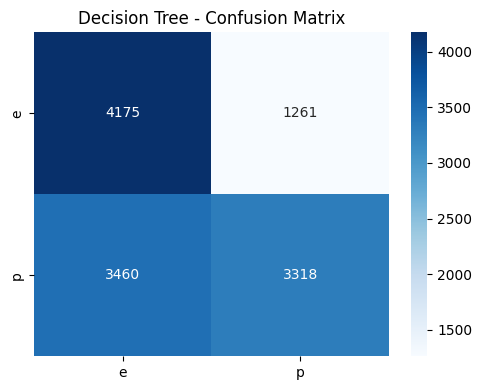

AUC: 0.65


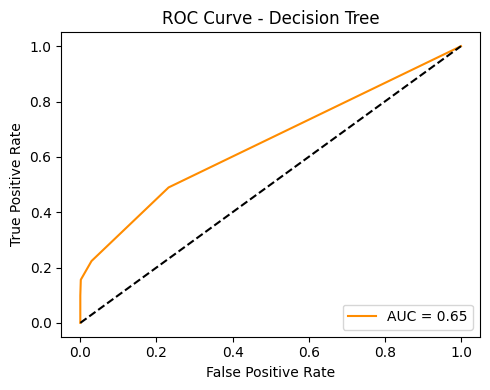

In [10]:
# Decision Tree sınıflandırmasını tanımlıyoruz
model = DecisionTreeClassifier(max_depth=3)# Maksimum 3 derinliğe sahip karar ağacı modelini oluşturuyoruz
model.fit(X_train, y_train)

#Test verisi üzerinden tahmin yaptırıyoruz
y_pred = model.predict(X_test)

# Metrikler hesaplamalarını yaptırıyoruz
acc = accuracy_score(y_test, y_pred) * 100
prec = precision_score(y_test, y_pred, average='macro') * 100
rec = recall_score(y_test, y_pred, average='macro') * 100
f1 = f1_score(y_test, y_pred, average='macro') * 100
cm = confusion_matrix(y_test, y_pred)

print("\nDecision Tree")
print(f"Accuracy: {acc:.2f}% | Precision: {prec:.2f}% | Recall: {rec:.2f}% | F1-Score: {f1:.2f}%")

# Confusion Matrix'ini görselleştirmek için gerekli verileri giriyoruz
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=le_y.classes_, yticklabels=le_y.classes_)
plt.title("Decision Tree - Confusion Matrix")
plt.tight_layout()
plt.show()

# ROC Curve ve AUC
try:#Modelin olasılık tahmini yapıp yapmadığını kontrol ettiriyoruz
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

    fpr, tpr, _ = roc_curve(y_test, y_proba)# ROC eğrisi için yanlış pozitif ve doğru pozitif oranlarını hesaplatıyoruz
    roc_auc = auc(fpr, tpr)
    print(f"AUC: {roc_auc:.2f}")

#Grafik için gerekli görsel verileri giriyoruz(grafik boyutu, referans çizgisi, eksen etiketleri,başlık,açıklama kutusu)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, color='darkorange', label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Decision Tree")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"AUC hesaplanamadı: {e}")

model_results.append({# Tabloda gösterilecek sonuçları ekliyoruz
    "Model": "Decision Tree",
    "Accuracy": round(acc, 2),
    "Precision": round(prec, 2),
    "Recall": round(rec, 2),
    "F1-Score": round(f1, 2),
    "AUC": round(roc_auc, 2) if 'roc_auc' in locals() else "-"
})

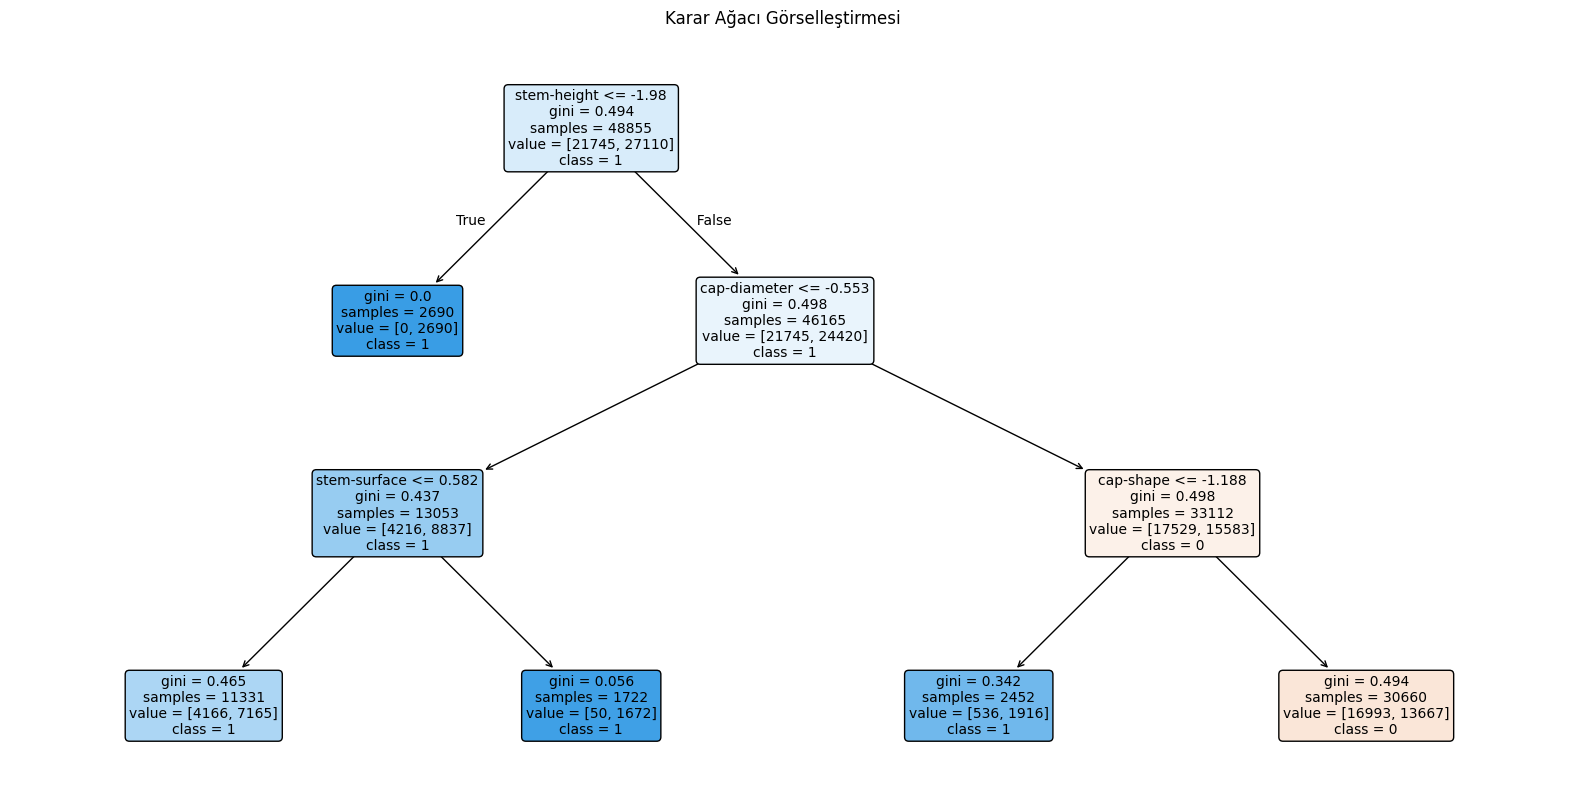

In [11]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Özellik isimleri
feature_names = df.drop("class", axis=1).columns

# Sınıf isimlerini string'e çeviriyoruz
class_names = [str(cls) for cls in model.classes_]

# Görselleştirme
plt.figure(figsize=(20, 10))
plot_tree(
    model,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Karar Ağacı Görselleştirmesi ")
plt.show()



Random Forest
Accuracy: 72.42% | Precision: 72.19% | Recall: 71.61% | F1-Score: 71.76%


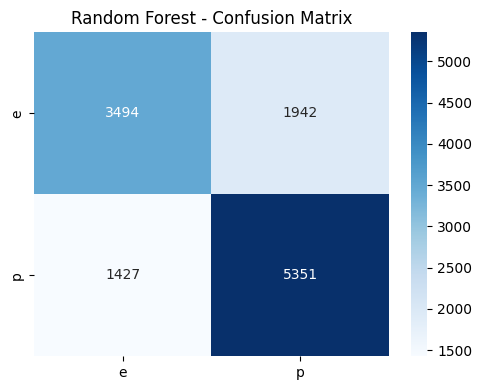

AUC: 0.79


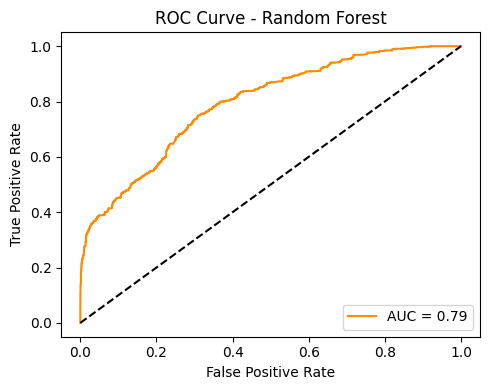

In [12]:
# Random Forest sınıflandırıcılarını oluşturuyoruz
model = RandomForestClassifier(max_depth=3)
model.fit(X_train, y_train)

# Test verileriyle tahmin yaptırıyoruz
y_pred = model.predict(X_test)

# Metriklerleri yüzdelik olarak hesaplatıyoruz
acc = accuracy_score(y_test, y_pred) * 100
prec = precision_score(y_test, y_pred, average='macro') * 100
rec = recall_score(y_test, y_pred, average='macro') * 100
f1 = f1_score(y_test, y_pred, average='macro') * 100
cm = confusion_matrix(y_test, y_pred)

print("\nRandom Forest")#Sonuçları yazdırıyoruz
print(f"Accuracy: {acc:.2f}% | Precision: {prec:.2f}% | Recall: {rec:.2f}% | F1-Score: {f1:.2f}%")

# Confusion Matrix'i için gerekli görsel verileri giriyoruz
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=le_y.classes_, yticklabels=le_y.classes_)
plt.title("Random Forest - Confusion Matrix")
plt.tight_layout()
plt.show()

# ROC Curve ve AUC
try:#Modelin olasılık tahmini yapıp yapmadığını kontrol ettiriyoruz
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]#Pozitif sınıf için olasılıkları hesaplatıyoruz
    else:
        y_proba = model.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    print(f"AUC: {roc_auc:.2f}")

 # ROC eğrisi çizimi için gerekli görsel verileri giriyoruz
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, color='darkorange', label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Random Forest")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"AUC hesaplanamadı: {e}")#Herhangi bir hata durumunda hata mesajı ekliyoruz


model_results.append({# Tabloda gösterilecek sonuçları ekliyoruz
    "Model": "Random Forest",
    "Accuracy": round(acc, 2),
    "Precision": round(prec, 2),
    "Recall": round(rec, 2),
    "F1-Score": round(f1, 2),
    "AUC": round(roc_auc, 2) if 'roc_auc' in locals() else "-"
})


K-Nearest Neighbors
Accuracy: 99.71% | Precision: 99.71% | Recall: 99.71% | F1-Score: 99.71%


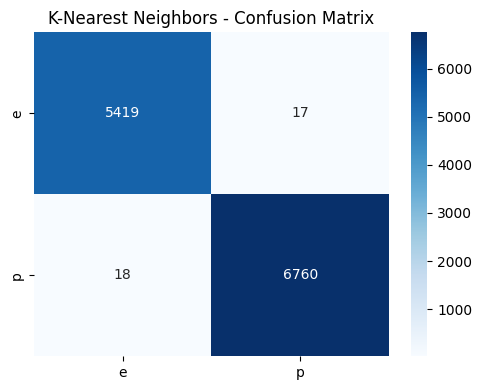

AUC: 1.00


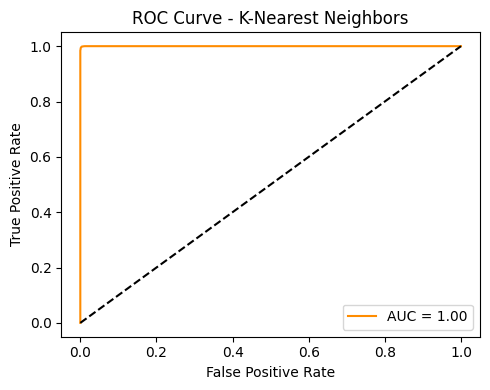

In [13]:
# K-Nearest Neighbors sınıflandırıcısını oluşturuyoruz
model = KNeighborsClassifier(n_neighbors=9)
model.fit(X_train, y_train)#Modeli eğitim verileriyle eğitiyoruz

# Test verileriyle tahmin yaptırıyoruz
y_pred = model.predict(X_test)

# Metriklerleri yüzdelik olarak hesaplatıyoruz
acc = accuracy_score(y_test, y_pred) * 100
prec = precision_score(y_test, y_pred, average='macro') * 100
rec = recall_score(y_test, y_pred, average='macro') * 100
f1 = f1_score(y_test, y_pred, average='macro') * 100
cm = confusion_matrix(y_test, y_pred)

print("\nK-Nearest Neighbors")#Sonuçları yazdırıyoruz
print(f"Accuracy: {acc:.2f}% | Precision: {prec:.2f}% | Recall: {rec:.2f}% | F1-Score: {f1:.2f}%")

# Confusion Matrix'i için gerekli görsel verileri giriyoruz
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=le_y.classes_, yticklabels=le_y.classes_)
plt.title("K-Nearest Neighbors - Confusion Matrix")
plt.tight_layout()
plt.show()

# ROC Curve ve AUC
try:#Modelin olasılık tahmini yapıp yapmadığını kontrol ettiriyoruz
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    print(f"AUC: {roc_auc:.2f}")# AUC değeri yazdırıyoruz

# ROC eğrisi çizimi için gerekli görsel verileri giriyoruz
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, color='darkorange', label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - K-Nearest Neighbors")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"AUC hesaplanamadı: {e}")

model_results.append({# Tabloda gösterilecek sonuçları ekliyoruz
    "Model": "K-Nearest Neighbors",
    "Accuracy": round(acc, 2),
    "Precision": round(prec, 2),
    "Recall": round(rec, 2),
    "F1-Score": round(f1, 2),
    "AUC": round(roc_auc, 2) if 'roc_auc' in locals() else "-"
})


Logistic Regression
Accuracy: 61.66% | Precision: 61.04% | Recall: 59.98% | F1-Score: 59.73%


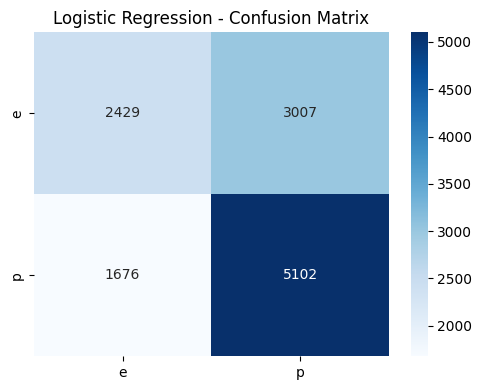

AUC: 0.67


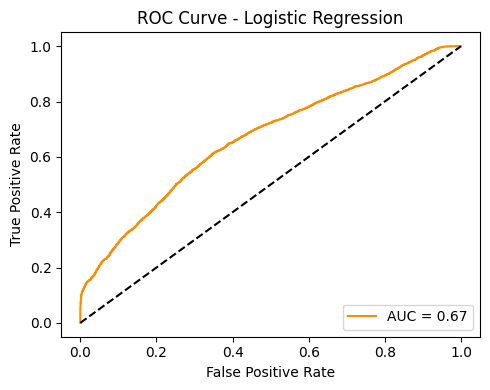

In [14]:
# Logistic Regression sınıflandırıcısını oluşturuyoruz
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# Test verileriyle tahmin yaptırıyoruz
y_pred = model.predict(X_test)

# Metriklerleri yüzdelik olarak hesaplatıyoruz
acc = accuracy_score(y_test, y_pred) * 100
prec = precision_score(y_test, y_pred, average='macro') * 100
rec = recall_score(y_test, y_pred, average='macro') * 100
f1 = f1_score(y_test, y_pred, average='macro') * 100
cm = confusion_matrix(y_test, y_pred)

print("\nLogistic Regression")
print(f"Accuracy: {acc:.2f}% | Precision: {prec:.2f}% | Recall: {rec:.2f}% | F1-Score: {f1:.2f}%")

# Confusion Matrix'i için gerekli görsel verileri giriyoruz
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=le_y.classes_, yticklabels=le_y.classes_)
plt.title("Logistic Regression - Confusion Matrix")
plt.tight_layout()
plt.show()

# ROC Curve ve AUC
try:#Modelin olasılık tahmini yapıp yapmadığını kontrol ettiriyoruz
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    print(f"AUC: {roc_auc:.2f}")# AUC değeri yazdırıyoruz

# ROC eğrisi çizimi için gerekli görsel verileri giriyoruz
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, color='darkorange', label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Logistic Regression")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"AUC hesaplanamadı: {e}")

model_results.append({# Tabloda gösterilecek sonuçları ekliyoruz
    "Model": "Logistic Regression",
    "Accuracy": round(acc, 2),
    "Precision": round(prec, 2),
    "Recall": round(rec, 2),
    "F1-Score": round(f1, 2),
    "AUC": round(roc_auc, 2) if 'roc_auc' in locals() else "-"
})


Naive Bayes
Accuracy: 58.32% | Precision: 57.30% | Recall: 56.60% | F1-Score: 56.22%


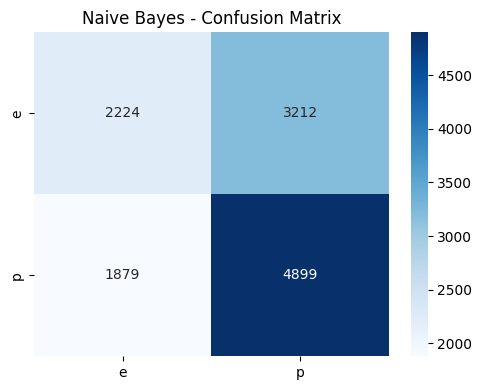

AUC: 0.63


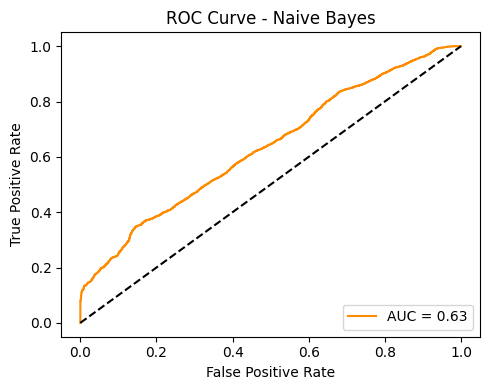

In [15]:
# Naive Bayes sınıflandırıcısını oluşturuyoruz
model = GaussianNB()
model.fit(X_train, y_train)

# Test verileriyle tahmin yaptırıyoruz
y_pred = model.predict(X_test)

# Metriklerleri yüzdelik olarak hesaplatıyoruz
acc = accuracy_score(y_test, y_pred) * 100
prec = precision_score(y_test, y_pred, average='macro') * 100
rec = recall_score(y_test, y_pred, average='macro') * 100
f1 = f1_score(y_test, y_pred, average='macro') * 100
cm = confusion_matrix(y_test, y_pred)

print("\nNaive Bayes")
print(f"Accuracy: {acc:.2f}% | Precision: {prec:.2f}% | Recall: {rec:.2f}% | F1-Score: {f1:.2f}%")

# Confusion Matrix'i için gerekli görsel verileri giriyoruz
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=le_y.classes_, yticklabels=le_y.classes_)
plt.title("Naive Bayes - Confusion Matrix")
plt.tight_layout()
plt.show()

# ROC Curve ve AUC
try:#Modelin olasılık tahmini yapıp yapmadığını kontrol ettiriyoruz
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    print(f"AUC: {roc_auc:.2f}")# AUC değeri yazdırıyoruz

# ROC eğrisi çizimi için gerekli görsel verileri giriyoruz
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, color='darkorange', label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Naive Bayes")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"AUC hesaplanamadı: {e}")

model_results.append({# Tabloda gösterilecek sonuçları ekliyoruz
    "Model": "Naive Bayes",
    "Accuracy": round(acc, 2),
    "Precision": round(prec, 2),
    "Recall": round(rec, 2),
    "F1-Score": round(f1, 2),
    "AUC": round(roc_auc, 2) if 'roc_auc' in locals() else "-"
})


Support Vector Machine
Accuracy: 98.30% | Precision: 98.28% | Recall: 98.27% | F1-Score: 98.28%


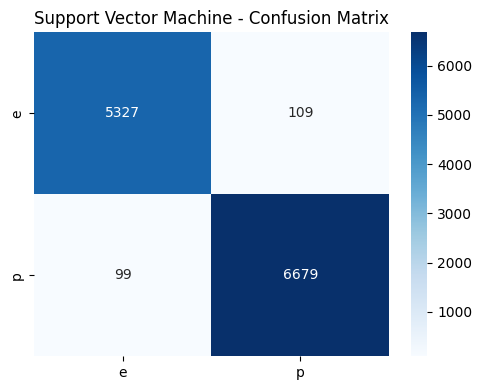

AUC: 1.00


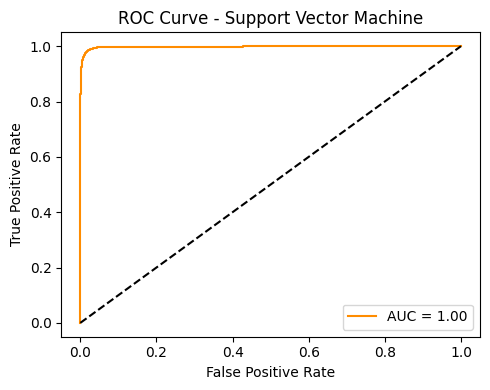

In [16]:
# Support Vector Machine sınıflandırıcısını oluşturuyoruz
model = SVC(probability=True)
model.fit(X_train, y_train)

# Test verileriyle tahmin yaptırıyoruz
y_pred = model.predict(X_test)

# Metriklerleri yüzdelik olarak hesaplatıyoruz
acc = accuracy_score(y_test, y_pred) * 100
prec = precision_score(y_test, y_pred, average='macro') * 100
rec = recall_score(y_test, y_pred, average='macro') * 100
f1 = f1_score(y_test, y_pred, average='macro') * 100
cm = confusion_matrix(y_test, y_pred)

print("\nSupport Vector Machine")
print(f"Accuracy: {acc:.2f}% | Precision: {prec:.2f}% | Recall: {rec:.2f}% | F1-Score: {f1:.2f}%")

# Confusion Matrix'i için gerekli görsel verileri giriyoruz
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=le_y.classes_, yticklabels=le_y.classes_)
plt.title("Support Vector Machine - Confusion Matrix")
plt.tight_layout()
plt.show()

# ROC Curve ve AUC
try:#Modelin olasılık tahmini yapıp yapmadığını kontrol ettiriyoruz
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    print(f"AUC: {roc_auc:.2f}")# AUC değeri yazdırıyoruz

# ROC eğrisi çizimi için gerekli görsel verileri giriyoruz
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, color='darkorange', label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Support Vector Machine")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"AUC hesaplanamadı: {e}")

model_results.append({# Tabloda gösterilecek sonuçları ekliyoruz
    "Model": "Support Vector Machine",
    "Accuracy": round(acc, 2),
    "Precision": round(prec, 2),
    "Recall": round(rec, 2),
    "F1-Score": round(f1, 2),
    "AUC": round(roc_auc, 2) if 'roc_auc' in locals() else "-"
})


Multilayer Perceptron (YSA)
Accuracy: 91.81% | Precision: 91.66% | Recall: 91.81% | F1-Score: 91.73%


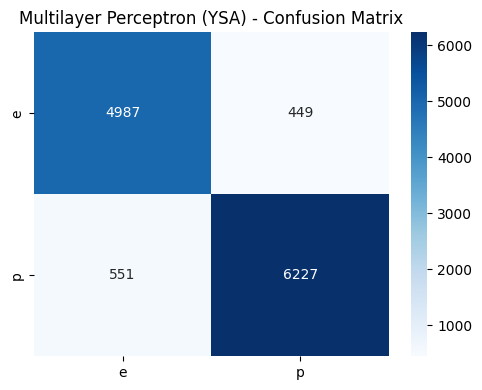

AUC: 0.97


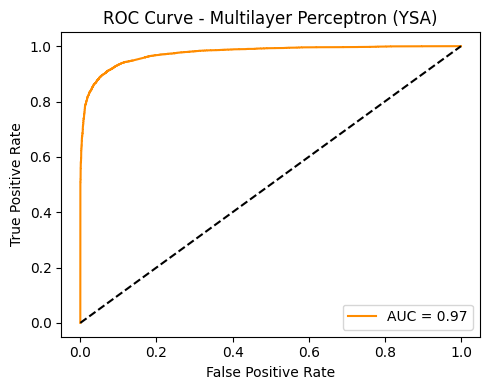

In [17]:
# Multilayer Perceptron (YSA) sınıflandırıcısını oluşturuyoruz
model = MLPClassifier(hidden_layer_sizes=(10,), max_iter=600)
model.fit(X_train, y_train)

# Test verileriyle tahmin yaptırıyoruz
y_pred = model.predict(X_test)

# Metriklerleri yüzdelik olarak hesaplatıyoruz
acc = accuracy_score(y_test, y_pred) * 100
prec = precision_score(y_test, y_pred, average='macro') * 100
rec = recall_score(y_test, y_pred, average='macro') * 100
f1 = f1_score(y_test, y_pred, average='macro') * 100
cm = confusion_matrix(y_test, y_pred)

print("\nMultilayer Perceptron (YSA)")
print(f"Accuracy: {acc:.2f}% | Precision: {prec:.2f}% | Recall: {rec:.2f}% | F1-Score: {f1:.2f}%")

# Confusion Matrix'i için gerekli görsel verileri giriyoruz
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=le_y.classes_, yticklabels=le_y.classes_)
plt.title("Multilayer Perceptron (YSA) - Confusion Matrix")
plt.tight_layout()
plt.show()

# ROC Curve ve AUC
try:#Modelin olasılık tahmini yapıp yapmadığını kontrol ettiriyoruz
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    print(f"AUC: {roc_auc:.2f}")# AUC değeri yazdırıyoruz

# ROC eğrisi çizimi için gerekli görsel verileri giriyoruz
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, color='darkorange', label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Multilayer Perceptron (YSA)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"AUC hesaplanamadı: {e}")

model_results.append({# Tabloda gösterilecek sonuçları ekliyoruz
    "Model": "Multilayer Perceptron (YSA)",
    "Accuracy": round(acc, 2),
    "Precision": round(prec, 2),
    "Recall": round(rec, 2),
    "F1-Score": round(f1, 2),
    "AUC": round(roc_auc, 2) if 'roc_auc' in locals() else "-"
})

In [18]:
import pandas as pd # Pandas kütüphanesi veri işlemleri için içe aktarılıyoruz
results_df = pd.DataFrame(model_results) # Her modelin metriklerini içeren listeyi tabloya çeviriyoruz
#Verileri görselleştiriyoruz
display(results_df)

,Model,Accuracy,Precision,Recall,F1-Score,AUC
0,Decision Tree,61.35,63.57,62.88,61.16,0.65
1,Random Forest,72.42,72.19,71.61,71.76,0.79
2,K-Nearest Neighbors,99.71,99.71,99.71,99.71,1.00
3,Logistic Regression,61.66,61.04,59.98,59.73,0.67
4,Naive Bayes,58.32,57.30,56.60,56.22,0.63
5,Support Vector Machine,98.30,98.28,98.27,98.28,1.00
6,Multilayer Perceptron (YSA),91.81,91.66,91.81,91.73,0.97


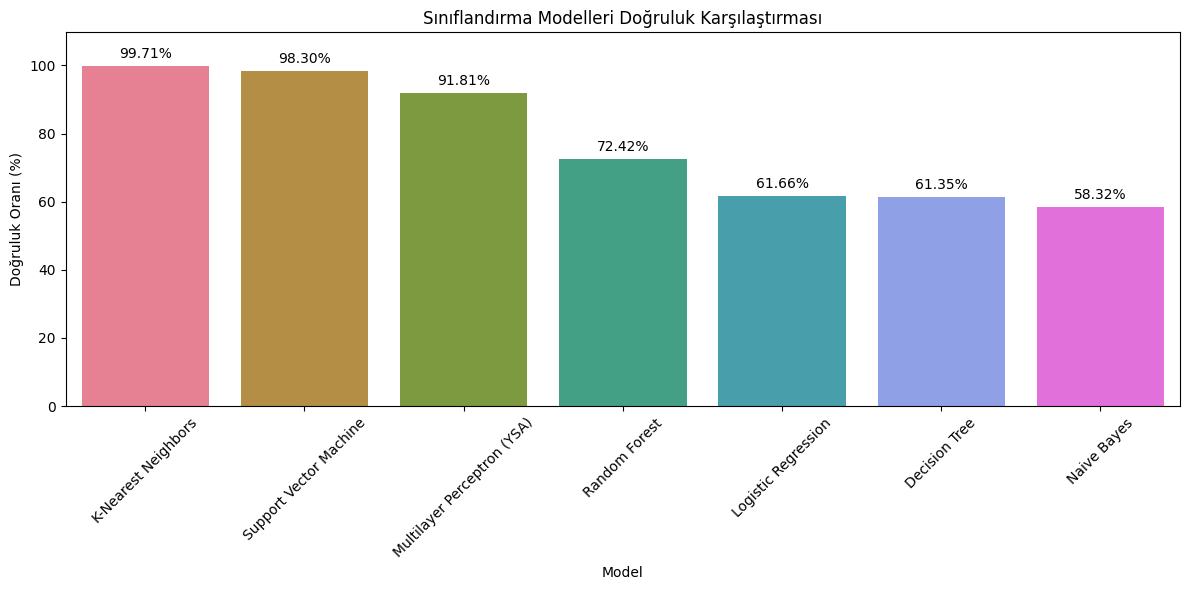

In [19]:


# Sonuçları tabloya çevir
results_df = pd.DataFrame(model_results)

# Doğruluk oranına göre sırala
results_df = results_df.sort_values(by="Accuracy", ascending=False)

# Her çubuğa farklı renk
colors = sns.color_palette("husl", len(results_df))

# Grafik çizimi
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=results_df,
    x="Model",
    y="Accuracy",
    hue="Model",
    palette=colors,
    dodge=False,
    legend=False
)

y_max = results_df["Accuracy"].max() + 10

# Etiketleri çubuk üstüne yaz
for i, row in enumerate(results_df.itertuples()):
    ax.text(
        i,
        row.Accuracy + 1.5,  # Etiket yüksekliği
        f"{row.Accuracy:.2f}%",
        ha='center',
        va='bottom',
        fontsize=10
    )

# Grafik ayarları
plt.title("Sınıflandırma Modelleri Doğruluk Karşılaştırması")
plt.ylabel("Doğruluk Oranı (%)")
plt.ylim(0, y_max)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


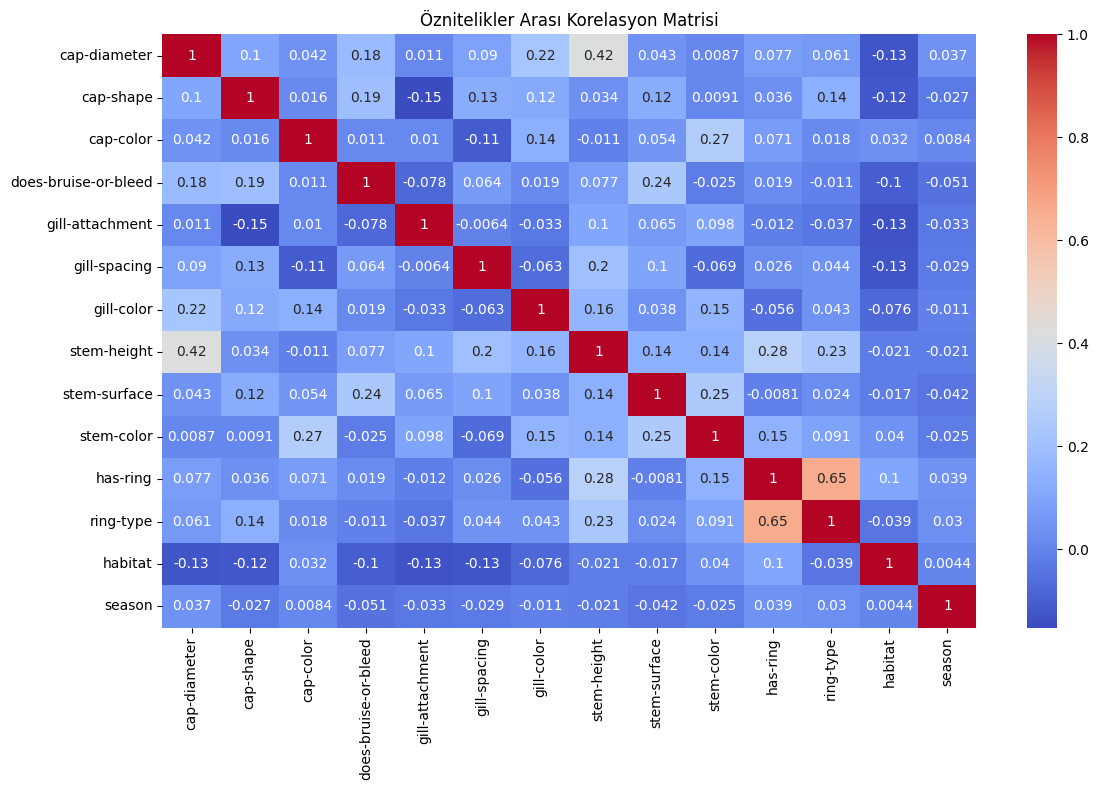

In [20]:
# Korelasyon matrisi çizimi
import seaborn as sns
import matplotlib.pyplot as plt

#Matrisi görselleştirmek için gerekli verileri giriyoruz
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title("Öznitelikler Arası Korelasyon Matrisi")
plt.tight_layout()
plt.show()



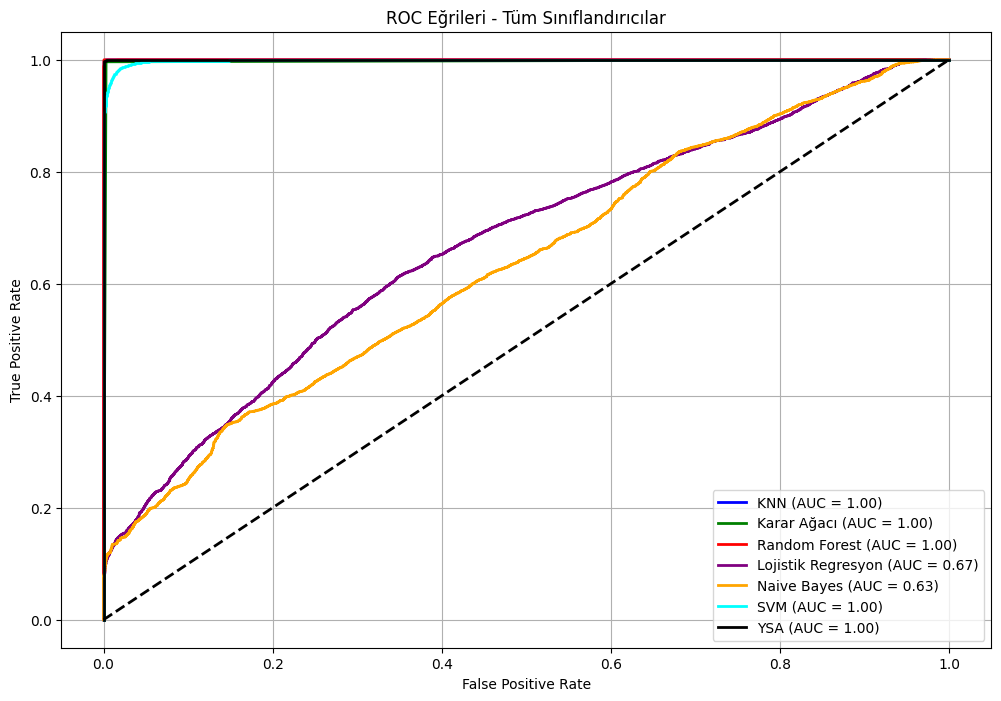

In [21]:
from sklearn.metrics import roc_curve, auc#ROC ve AUC hesaplamak,sınıflandırıcılar ve grafik çizimi için gerekli kütüphaneleri ekliyoruz
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from itertools import cycle

# Etiketleri binary forma çeviriyoruz
y_test_bin = label_binarize(y_test, classes=[0, 1])

# Modelleri tanımlıyoruz
models = {
    "KNN": KNeighborsClassifier(),
    "Karar Ağacı": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Lojistik Regresyon": LogisticRegression(max_iter=1000),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True),
    "YSA": MLPClassifier(max_iter=1000, random_state=42)
}

# ROC Eğrisi çizimi için gerekli görel verileri giriyoruz
plt.figure(figsize=(12, 8))
colors = cycle(['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'black'])

# Her model için ROC eğrisi hesaplanıyor ve çiziliyoruz
for (name, model), color in zip(models.items(), colors):
    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

#Grafikleri görselleştiren verileri giriyoruz
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrileri - Tüm Sınıflandırıcılar")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



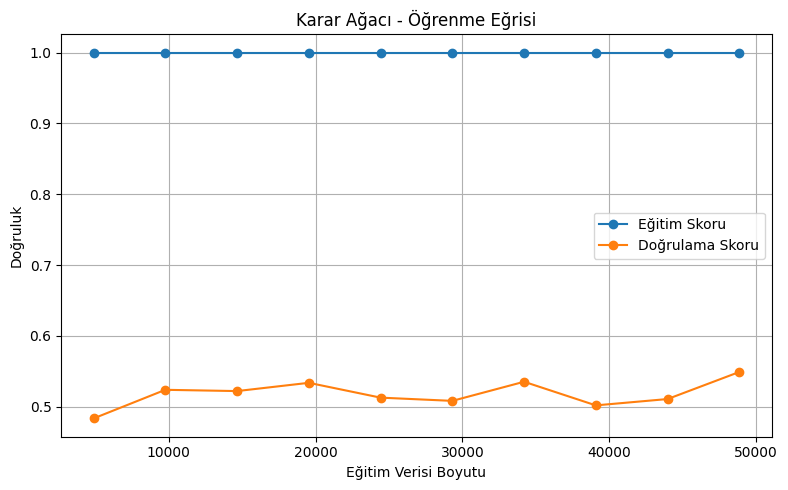

In [22]:
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np

# Modeli tanımla
model = DecisionTreeClassifier(random_state=42)

# Öğrenme eğrisi verilerini hesapla
train_sizes, train_scores, valid_scores = learning_curve(
    model, X_scaled, y, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Ortalama skorlar
train_mean = np.mean(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)

# Grafik çizimi
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Eğitim Skoru')
plt.plot(train_sizes, valid_mean, 'o-', label='Doğrulama Skoru')
plt.title("Karar Ağacı - Öğrenme Eğrisi")
plt.xlabel("Eğitim Verisi Boyutu")
plt.ylabel("Doğruluk")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


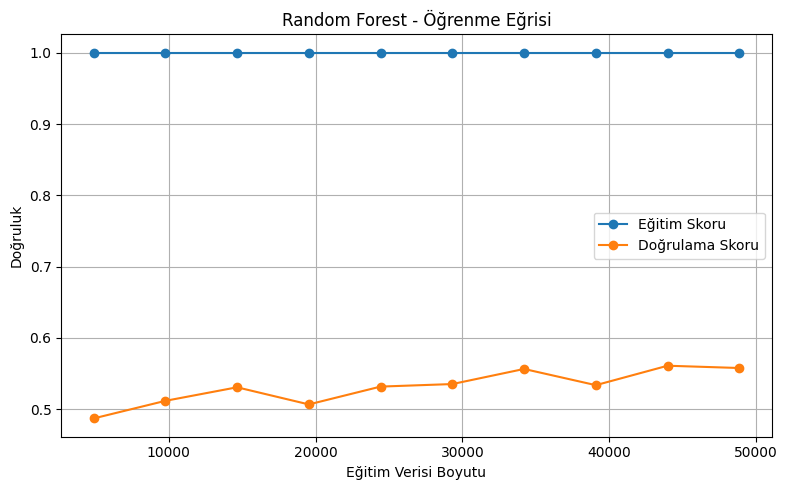

In [23]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
train_sizes, train_scores, valid_scores = learning_curve(
    model, X_scaled, y, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)
train_mean = np.mean(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Eğitim Skoru')
plt.plot(train_sizes, valid_mean, 'o-', label='Doğrulama Skoru')
plt.title("Random Forest - Öğrenme Eğrisi")
plt.xlabel("Eğitim Verisi Boyutu")
plt.ylabel("Doğruluk")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


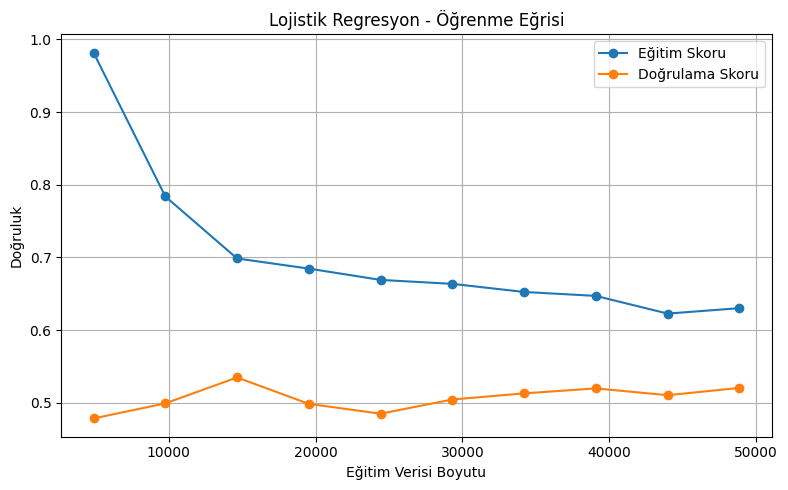

In [24]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, random_state=42)
train_sizes, train_scores, valid_scores = learning_curve(
    model, X_scaled, y, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)
train_mean = np.mean(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Eğitim Skoru')
plt.plot(train_sizes, valid_mean, 'o-', label='Doğrulama Skoru')
plt.title("Lojistik Regresyon - Öğrenme Eğrisi")
plt.xlabel("Eğitim Verisi Boyutu")
plt.ylabel("Doğruluk")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


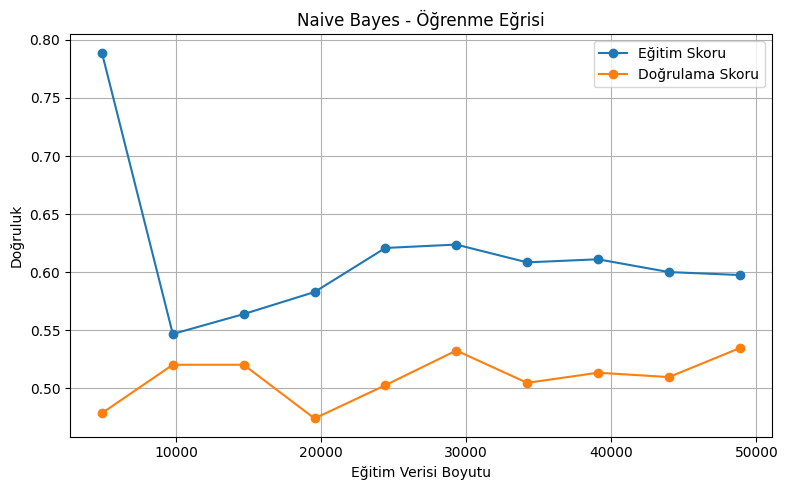

In [25]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
train_sizes, train_scores, valid_scores = learning_curve(
    model, X_scaled, y, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)
train_mean = np.mean(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Eğitim Skoru')
plt.plot(train_sizes, valid_mean, 'o-', label='Doğrulama Skoru')
plt.title("Naive Bayes - Öğrenme Eğrisi")
plt.xlabel("Eğitim Verisi Boyutu")
plt.ylabel("Doğruluk")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


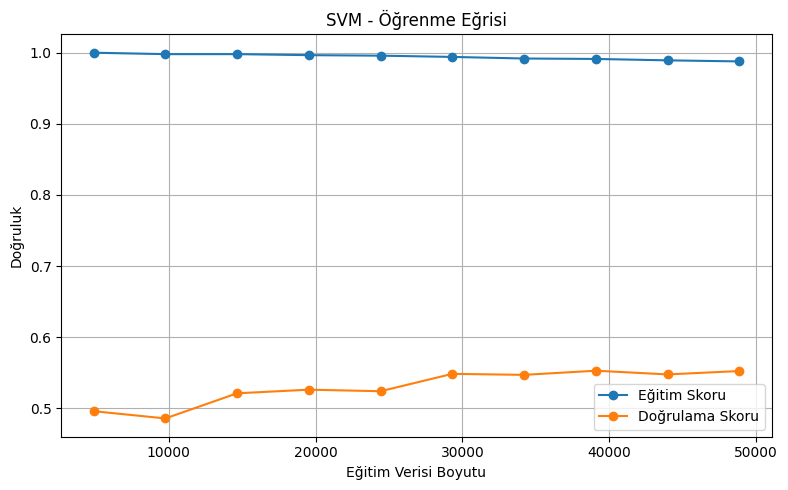

In [26]:
from sklearn.svm import SVC

model = SVC()
train_sizes, train_scores, valid_scores = learning_curve(
    model, X_scaled, y, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)
train_mean = np.mean(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Eğitim Skoru')
plt.plot(train_sizes, valid_mean, 'o-', label='Doğrulama Skoru')
plt.title("SVM - Öğrenme Eğrisi")
plt.xlabel("Eğitim Verisi Boyutu")
plt.ylabel("Doğruluk")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


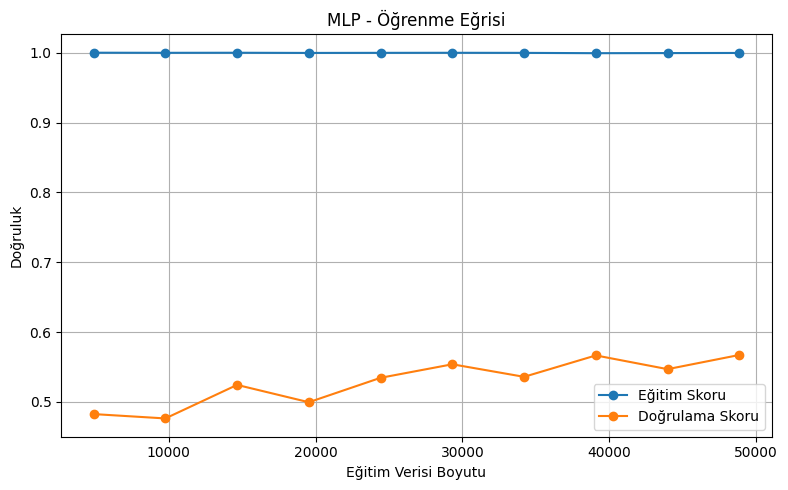

In [27]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
train_sizes, train_scores, valid_scores = learning_curve(
    model, X_scaled, y, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)
train_mean = np.mean(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Eğitim Skoru')
plt.plot(train_sizes, valid_mean, 'o-', label='Doğrulama Skoru')
plt.title("MLP - Öğrenme Eğrisi")
plt.xlabel("Eğitim Verisi Boyutu")
plt.ylabel("Doğruluk")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


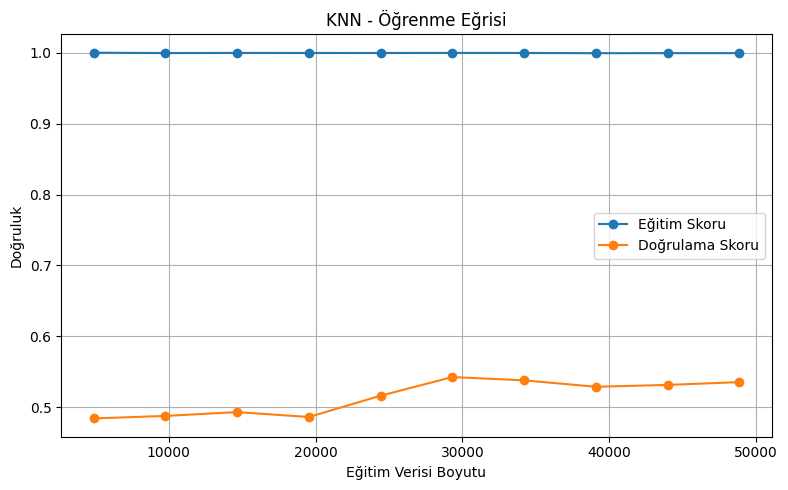

In [28]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
train_sizes, train_scores, valid_scores = learning_curve(
    model, X_scaled, y, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)
train_mean = np.mean(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Eğitim Skoru')
plt.plot(train_sizes, valid_mean, 'o-', label='Doğrulama Skoru')
plt.title("KNN - Öğrenme Eğrisi")
plt.xlabel("Eğitim Verisi Boyutu")
plt.ylabel("Doğruluk")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
